# Higher order density histogram estimators for density estimation 

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time
import math

In [2]:
max_exponent = 16
min_exponent = 4 - 1 # adds one automatically in the for loop

In [3]:
def dd_partition(x_data, kappa, tolerance):
    '''compute the data-dependent partition of the dataset x_data with 2^kappa cells'''
    SS = np.empty(shape = (kappa+1, 2**kappa), dtype='object')
    SS[0][0] = x_data

    RR = np.empty(shape = (kappa+1, 2**kappa), dtype='object')
    RR1 = np.zeros(2)
    RR1[0] = np.amin(x_data[:, 0]) - tolerance
    RR1[1] = np.amax(x_data[:, 0]) + tolerance
    RR[0][0] = RR1
    
    for p in range(kappa):
        for q in range(2**p):
            S = np.copy(SS[p][q])
                    
            med = np.median(S[:, 0])
            B = np.copy(S[S[:, 0].argsort()])
            S = np.copy(B)
            t = int(len(S[:, 0])/2)
            SS[p + 1][2*q] = np.copy(S[t:len(S),:])
            SS[p + 1][2*q + 1] = np.copy(S[0:t,:])

            RR[p + 1][2 * q] = np.copy(RR[p][q])
            RR[p + 1][2 * q][0] = np.copy(med)
            RR[p + 1][2 * q + 1] = np.copy(RR[p][q])
            RR[p + 1][2 * q + 1][1] = np.copy(med)


    partition = np.zeros(2**kappa + 1)
    
    partition[0] = RR[kappa][2**kappa - 1][0]
    for i in range(2**kappa):
        partition[i+1] = RR[kappa][2**kappa - i - 1][1]

    return partition

In [4]:
def mod_partition(partition, partition2, diff, a):
    if diff == 0 or a == 0:
        return partition

    n = len(partition)
    m = len(partition2)
    modified_partition = np.zeros(len(partition) + (2**diff - 1)*2*a)
    l = len(modified_partition)

    if n < 2**2:
        return partition2
    
    modified_partition[0:a*(2**diff) + 1] = partition2[0:a*(2**diff) + 1]
    modified_partition[a*(2**diff) + 1:- a*(2**diff)] = partition[a+1:n-a]
    modified_partition[- a*(2**diff) -1:] = partition2[- a*(2**diff) -1:]

    return modified_partition

In [5]:
def localization(point, partition, index):
    '''localizes the cell index, in which the point is contained'''
    l = len(partition)
    if l == 1:
        return index
    elif point <= partition[(math.floor(l/2))]:
        return localization(point, partition[0:math.floor(l/2)], index+0)
    elif point > partition[(math.floor(l/2))]:
        return localization(point, partition[math.floor(l/2):l], index+math.floor(l/2))

In [6]:
def compute_kB(x_data, partition):
    '''computes the amount of datapoints in each cells'''

    kB_con = np.zeros((len(partition)-1))
    kB_lin = np.zeros(2*(len(partition)-1))
    kB_qud = np.zeros(3*(len(partition)-1))
    
    for point in x_data:
    
        index = localization(point, partition, 0)
        left = partition[index]
        right = partition[index+1]
        
        for m in range(1,4):
            for sub in range(m):
                a = left + sub/(m) * (right - left)
                b = left + (sub+1)/(m) * (right - left)

                if a <= point and point < b:
                    if m == 1:
                        kB_con[index] += 1
                    elif m == 2:
                        kB_lin[2*index + sub] += 1
                    elif m == 3:
                        kB_qud[3*index + sub] += 1

    return [kB_con, kB_lin, kB_qud]

In [7]:
def p0(x, d, alpha):
    '''probability density function of a multivariate standard normal distribution'''

    Mean = [0]*d
    Cov = alpha*np.identity(d)
    value = multivariate_normal.pdf(x, mean=Mean, cov=Cov)

    return value

In [8]:
def con_value(point, partition, kN, N):
    
    index = localization(point, partition, 0)
    h = partition[index + 1] - partition[index]
    
    val = 1/h * kN[index]/N

    return val

In [9]:
def lin_value(point, partition, kB, N):

    index = localization(point, partition, 0)
    h = partition[index + 1] - partition[index]
    
    g_hat = (1/h) * (kB[2*index] + kB[2*index + 1])/N
    g_plus = (2/h)*kB[2*index + 1]/N
    g_minus = (2/h)*kB[2*index]/N

    mid = (partition[index] + partition[index+1])/2

    val = g_hat + 2/h * (point - mid) * (g_plus - g_minus)

    return val

In [10]:
def calc_parabola(x1, y1, x2, y2, x3, y3):
    '''compute the coefficients for the parabola'''
    denom = (x1-x2) * (x1-x3) * (x2-x3)
    A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    C     = (x2 * x3 * (x2-x3) * y1 + x3 * x1 * (x3-x1) * y2 + x1 * x2 * (x1-x2) * y3) / denom

    return [A, B, C]

In [11]:
def qud_value(point, partition, kB, N):

    index = localization(point, partition, 0)
    h = partition[index + 1] - partition[index]

    x_1 = partition[index] + 1/6 * (partition[index+1] - partition[index])
    x_2 = partition[index] + 1/2 * (partition[index+1] - partition[index])
    x_3 = partition[index] + 5/6 * (partition[index+1] - partition[index])

    y_1 = (3/h) * kB[3*index]/N
    y_2 = (3/h) * kB[3*index+1]/N
    y_3 = (3/h) * kB[3*index+2]/N

    [a, b, c] = calc_parabola(x_1, y_1, x_2, y_2, x_3, y_3)

    val = a*point**2 + b*point + c

    return val

In [12]:
plot_length = 1000

In [13]:
N = 2**max_exponent

d = 1
alpha = 1

Mean = [0]*d
Cov = alpha*np.identity(d)

x_data = np.random.multivariate_normal(Mean, Cov, N)

## density histogram estimation

### for h fixed

In [14]:
h = 1/3

In [15]:
l = max_exponent - min_exponent
error = np.zeros((3, l, 3))

plot = True
if l > 5:
    plot = False

for exponent in range(min_exponent, max_exponent):

    t0 = time.time()

    # --- FOR CONSTANT PARTITIONING ------------------------------------------------------------- #

    N_tilde = 2**(exponent+1)
    sub_x_data = x_data[0:N_tilde]

    length = int((sub_x_data.max() - sub_x_data.min()) // h) + 1
    tolerance = (h - abs((sub_x_data.max() - sub_x_data.min()) % h)) / 2
    
    con_partition = np.linspace(sub_x_data.min() - tolerance, sub_x_data.max() + tolerance, length + 1, endpoint=True)
    lin_partition = np.linspace(sub_x_data.min() - tolerance, sub_x_data.max() + tolerance, 2*length + 1, endpoint=True)
    qud_partition = np.linspace(sub_x_data.min() - tolerance, sub_x_data.max() + tolerance, 3*length + 1, endpoint=True)

    interval = np.linspace(min(con_partition), max(con_partition), plot_length, endpoint=True)
    y_values = p0(interval, d, alpha)

    [kB_con, kB_lin, kB_qud] = compute_kB(sub_x_data, con_partition)

    con_est = np.zeros(plot_length)
    lin_est = np.zeros(plot_length)
    qud_est = np.zeros(plot_length)

    for i in range(plot_length):
        con_est[i] = con_value(interval[i], con_partition, kB_con, N_tilde)
        lin_est[i] = lin_value(interval[i], con_partition, kB_lin, N_tilde)
        qud_est[i] = qud_value(interval[i], con_partition, kB_qud, N_tilde)

    # --- FOR DATA-DEPENDEND PARTITIONING ------------------------------------------------------- #

    kappa = 0
    while 2**(kappa+1) < length:   # computes max{kappa: 2**kappa < length}
        kappa = kappa + 1 
    if exponent+1 < kappa:
        kappa = exponent+1
    kN = 2**(exponent+1 - kappa)
    R = 2**kappa
    
    
    datadependent_partition = dd_partition(sub_x_data, kappa, 1/2)

    con_dd_partition = datadependent_partition
    lin_dd_partition = np.zeros(2*R+1)
    lin_dd_partition[0::2] = datadependent_partition
    lin_dd_partition[1::2] = (datadependent_partition[0:R] + datadependent_partition[1:R+1]) / 2
    qud_dd_partition = np.zeros(3*R+1)
    qud_dd_partition[0::3] = datadependent_partition
    qud_dd_partition[1::3] = datadependent_partition[0:R] + 1/3 * (datadependent_partition[1:R+1] - datadependent_partition[0:R])
    qud_dd_partition[2::3] = datadependent_partition[0:R] + 2/3 * (datadependent_partition[1:R+1] - datadependent_partition[0:R])

    [kB_dd_con, kB_dd_lin, kB_dd_qud] = compute_kB(sub_x_data, datadependent_partition)

    dd_interval = np.linspace(min(datadependent_partition), max(datadependent_partition), plot_length, endpoint=True)
    dd_y_values = p0(dd_interval, d, alpha)

    con_dd_est = np.zeros(plot_length)
    lin_dd_est = np.zeros(plot_length)
    qud_dd_est = np.zeros(plot_length)

    for i in range(plot_length):
        con_dd_est[i] = con_value(dd_interval[i], con_dd_partition, kB_dd_con, N_tilde)
        lin_dd_est[i] = lin_value(dd_interval[i], con_dd_partition, kB_dd_lin, N_tilde)
        qud_dd_est[i] = qud_value(dd_interval[i], con_dd_partition, kB_dd_qud, N_tilde)

    # --- FOR MODIFIED PARTITIONING ------------------------------------------------------------- #

    kN2 = 2**math.ceil((exponent+1)/2)
    kappa2 = math.floor((exponent+1)/2)
    R2 = 2**kappa2

    diff = kappa2 - kappa
    if diff < 0:
        diff = 0

    datadependent_partition2 = dd_partition(sub_x_data, kappa2, 1/2)

    modified_partition = mod_partition(datadependent_partition, datadependent_partition2, diff, 1)
    L = len(modified_partition) - 1

    con_mod_partition = modified_partition
    lin_mod_partition = np.zeros(2*L+1)
    lin_mod_partition[0::2] = modified_partition
    lin_mod_partition[1::2] = (modified_partition[0:L] + modified_partition[1:L+1]) / 2
    qud_mod_partition = np.zeros(3*L+1)
    qud_mod_partition[0::3] = modified_partition
    qud_mod_partition[1::3] = modified_partition[0:L] + 1/3 * (modified_partition[1:L+1] - modified_partition[0:L])
    qud_mod_partition[2::3] = modified_partition[0:L] + 2/3 * (modified_partition[1:L+1] - modified_partition[0:L])

    [kB_mod_con, kB_mod_lin, kB_mod_qud] = compute_kB(sub_x_data, modified_partition)

    mod_interval = np.linspace(min(modified_partition), max(modified_partition), plot_length, endpoint=True)
    mod_y_values = p0(mod_interval, d, alpha)

    con_mod_est = np.zeros(plot_length)
    lin_mod_est = np.zeros(plot_length)
    qud_mod_est = np.zeros(plot_length)

    for i in range(plot_length):
        con_mod_est[i] = con_value(mod_interval[i], con_mod_partition, kB_mod_con, N_tilde)
        lin_mod_est[i] = lin_value(mod_interval[i], con_mod_partition, kB_mod_lin, N_tilde)
        qud_mod_est[i] = qud_value(mod_interval[i], con_mod_partition, kB_mod_qud, N_tilde)

    t1 = time.time()

    print('N = 2^{}: time = {}'.format(exponent+1, round(t1-t0, 4)))

    if plot:

        fig, ax = plt.subplots(3, 3, figsize = (18, 15))

        # --- FOR CONSTANT PARTITIONING ----------------------------------------------------- #

        ax[0][0].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')
        ax[0][1].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')
        ax[0][2].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')

        ax[0][0].plot(con_partition, np.zeros_like(con_partition), '|', markersize = 20, color = 'grey')
        ax[0][1].plot(lin_partition[0::2], np.zeros_like(lin_partition[0::2]), '|', markersize = 20, color = 'grey')
        ax[0][1].plot(lin_partition[1::2], np.zeros_like(lin_partition[1::2]), '|', markersize = 10, color = 'grey')
        ax[0][2].plot(qud_partition[0::3], np.zeros_like(qud_partition[0::3]), '|', markersize = 20, color = 'grey')
        ax[0][2].plot(qud_partition[1::3], np.zeros_like(qud_partition[1::3]), '|', markersize = 10, color = 'grey')
        ax[0][2].plot(qud_partition[2::3], np.zeros_like(qud_partition[2::3]), '|', markersize = 10, color = 'grey')

        for i in range(plot_length):
            con_val = con_value(interval[i], con_partition, kB_con, N_tilde)
            lin_val = con_value(interval[i], lin_partition, kB_lin, N_tilde)
            qud_val = con_value(interval[i], qud_partition, kB_qud, N_tilde)
            ax[0][0].plot(interval[i], con_val, '_', markersize = 1, color = 'blue', alpha = 0.15, label='constant')
            ax[0][1].plot(interval[i], lin_val, '_', markersize = 1, color = 'green', alpha = 0.15, label='linear')
            ax[0][2].plot(interval[i], qud_val, '_', markersize = 1, color = 'red', alpha = 0.15, label='quadratic')

        ax[0][0].plot(interval, con_est, '--', color = 'blue', label='constant')
        ax[0][1].plot(interval, lin_est, '--', color = 'green', label='linear')
        ax[0][2].plot(interval, qud_est, '--', color = 'red', label='quadratic')
        ax[0][0].plot(interval, y_values, '--', color = 'grey')
        ax[0][1].plot(interval, y_values, '--', color = 'grey')
        ax[0][2].plot(interval, y_values, '--', color = 'grey')

        # --- FOR DATA-DEPENDEND PARTITIONING ----------------------------------------------- #

        ax[1][0].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')
        ax[1][1].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')
        ax[1][2].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')

        ax[1][0].plot(con_dd_partition, np.zeros_like(con_dd_partition), '|', markersize = 20, color = 'grey')
        ax[1][1].plot(lin_dd_partition[0::2], np.zeros_like(lin_dd_partition[0::2]), '|', markersize = 20, color = 'grey')
        ax[1][1].plot(lin_dd_partition[1::2], np.zeros_like(lin_dd_partition[1::2]), '|', markersize = 10, color = 'grey')
        ax[1][2].plot(qud_dd_partition[0::3], np.zeros_like(qud_dd_partition[0::3]), '|', markersize = 20, color = 'grey')
        ax[1][2].plot(qud_dd_partition[1::3], np.zeros_like(qud_dd_partition[1::3]), '|', markersize = 10, color = 'grey')
        ax[1][2].plot(qud_dd_partition[2::3], np.zeros_like(qud_dd_partition[2::3]), '|', markersize = 10, color = 'grey')

        for i in range(plot_length):
            con_val = con_value(dd_interval[i], con_dd_partition, kB_dd_con, N_tilde)
            lin_val = con_value(dd_interval[i], lin_dd_partition, kB_dd_lin, N_tilde)
            qud_val = con_value(dd_interval[i], qud_dd_partition, kB_dd_qud, N_tilde)
            ax[1][0].plot(dd_interval[i], con_val, '_', markersize = 1, color = 'blue', alpha = 0.15, label='constant')
            ax[1][1].plot(dd_interval[i], lin_val, '_', markersize = 1, color = 'green', alpha = 0.15, label='linear')
            ax[1][2].plot(dd_interval[i], qud_val, '_', markersize = 1, color = 'red', alpha = 0.15, label='quadratic')

        ax[1][0].plot(dd_interval, con_dd_est, '--', color = 'blue', label='constant')
        ax[1][1].plot(dd_interval, lin_dd_est, '--', color = 'green', label='linear')
        ax[1][2].plot(dd_interval, qud_dd_est, '--', color = 'red', label='quadratic')
        ax[1][0].plot(dd_interval, dd_y_values, '--', color = 'grey')
        ax[1][1].plot(dd_interval, dd_y_values, '--', color = 'grey')
        ax[1][2].plot(dd_interval, dd_y_values, '--', color = 'grey')

        # --- FOR MODIFIED PARTITIONING ----------------------------------------------------- #

        ax[2][0].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')
        ax[2][1].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')
        ax[2][2].plot(sub_x_data, np.zeros_like(sub_x_data), '.', alpha = 0.2, markersize = 5, color = 'grey')

        ax[2][0].plot(con_mod_partition, np.zeros_like(con_mod_partition), '|', markersize = 20, color = 'grey')
        ax[2][1].plot(lin_mod_partition[0::2], np.zeros_like(lin_mod_partition[0::2]), '|', markersize = 20, color = 'grey')
        ax[2][1].plot(lin_mod_partition[1::2], np.zeros_like(lin_mod_partition[1::2]), '|', markersize = 10, color = 'grey')
        ax[2][2].plot(qud_mod_partition[0::3], np.zeros_like(qud_mod_partition[0::3]), '|', markersize = 20, color = 'grey')
        ax[2][2].plot(qud_mod_partition[1::3], np.zeros_like(qud_mod_partition[1::3]), '|', markersize = 10, color = 'grey')
        ax[2][2].plot(qud_mod_partition[2::3], np.zeros_like(qud_mod_partition[2::3]), '|', markersize = 10, color = 'grey')

        for i in range(plot_length):
            con_val = con_value(mod_interval[i], con_mod_partition, kB_mod_con, N_tilde)
            lin_val = con_value(mod_interval[i], lin_mod_partition, kB_mod_lin, N_tilde)
            qud_val = con_value(mod_interval[i], qud_mod_partition, kB_mod_qud, N_tilde)
            ax[2][0].plot(mod_interval[i], con_val, '_', markersize = 1, color = 'blue', alpha = 0.15, label='constant')
            ax[2][1].plot(mod_interval[i], lin_val, '_', markersize = 1, color = 'green', alpha = 0.15, label='linear')
            ax[2][2].plot(mod_interval[i], qud_val, '_', markersize = 1, color = 'red', alpha = 0.15, label='quadratic')

        ax[2][0].plot(mod_interval, con_mod_est, '--', color = 'blue', label='constant')
        ax[2][1].plot(mod_interval, lin_mod_est, '--', color = 'green', label='linear')
        ax[2][2].plot(mod_interval, qud_mod_est, '--', color = 'red', label='quadratic')
        ax[2][0].plot(mod_interval, mod_y_values, '--', color = 'grey')
        ax[2][1].plot(mod_interval, mod_y_values, '--', color = 'grey')
        ax[2][2].plot(mod_interval, mod_y_values, '--', color = 'grey')

        fig.suptitle(r'comparison of estimators for $N = 2^{{}}$ datapoints with $\kappa = {}$, $\kappa_2 = {}$'.format(exponent+1, kappa, kappa2))
        ax[0][0].set_title(r'$f_{n, 0}$ for constant partition', size = 16)
        ax[0][1].set_title(r'$f_{n, 1}$ for constant partition', size = 16)
        ax[0][2].set_title(r'$f_{n, 2}$ for constant partition', size = 16)
        ax[1][0].set_title(r'$f_{n, 0}$ for data-dependent partition', size = 16)
        ax[1][1].set_title(r'$f_{n, 1}$ for data-dependent partition', size = 16)
        ax[1][2].set_title(r'$f_{n, 2}$ for data-dependent partition', size = 16)
        ax[2][0].set_title(r'$f_{n, 0}$ for modified partition', size = 16)
        ax[2][1].set_title(r'$f_{n, 1}$ for modified partition', size = 16)
        ax[2][2].set_title(r'$f_{n, 2}$ for modified partition', size = 16)

        plt.show()

    error[0, exponent - min_exponent, 0] = (abs(con_est - y_values)).max()
    error[1, exponent - min_exponent, 0] = (abs(lin_est - y_values)).max()
    error[2, exponent - min_exponent, 0] = (abs(qud_est - y_values)).max()
    error[0, exponent - min_exponent, 1] = (abs(con_dd_est - dd_y_values)).max()
    error[1, exponent - min_exponent, 1] = (abs(lin_dd_est - dd_y_values)).max()
    error[2, exponent - min_exponent, 1] = (abs(qud_dd_est - dd_y_values)).max()
    error[0, exponent - min_exponent, 2] = (abs(con_mod_est - mod_y_values)).max()
    error[1, exponent - min_exponent, 2] = (abs(lin_mod_est - mod_y_values)).max()
    error[2, exponent - min_exponent, 2] = (abs(qud_mod_est - mod_y_values)).max()

N = 2^4: time = 0.0898
N = 2^5: time = 0.0728
N = 2^6: time = 0.0753
N = 2^7: time = 0.1218
N = 2^8: time = 0.0789
N = 2^9: time = 0.1001
N = 2^10: time = 0.1544
N = 2^11: time = 0.2107
N = 2^12: time = 0.374
N = 2^13: time = 0.6736
N = 2^14: time = 1.3703
N = 2^15: time = 2.5919
N = 2^16: time = 5.1141


for h = 0.3333333333333333 fixed


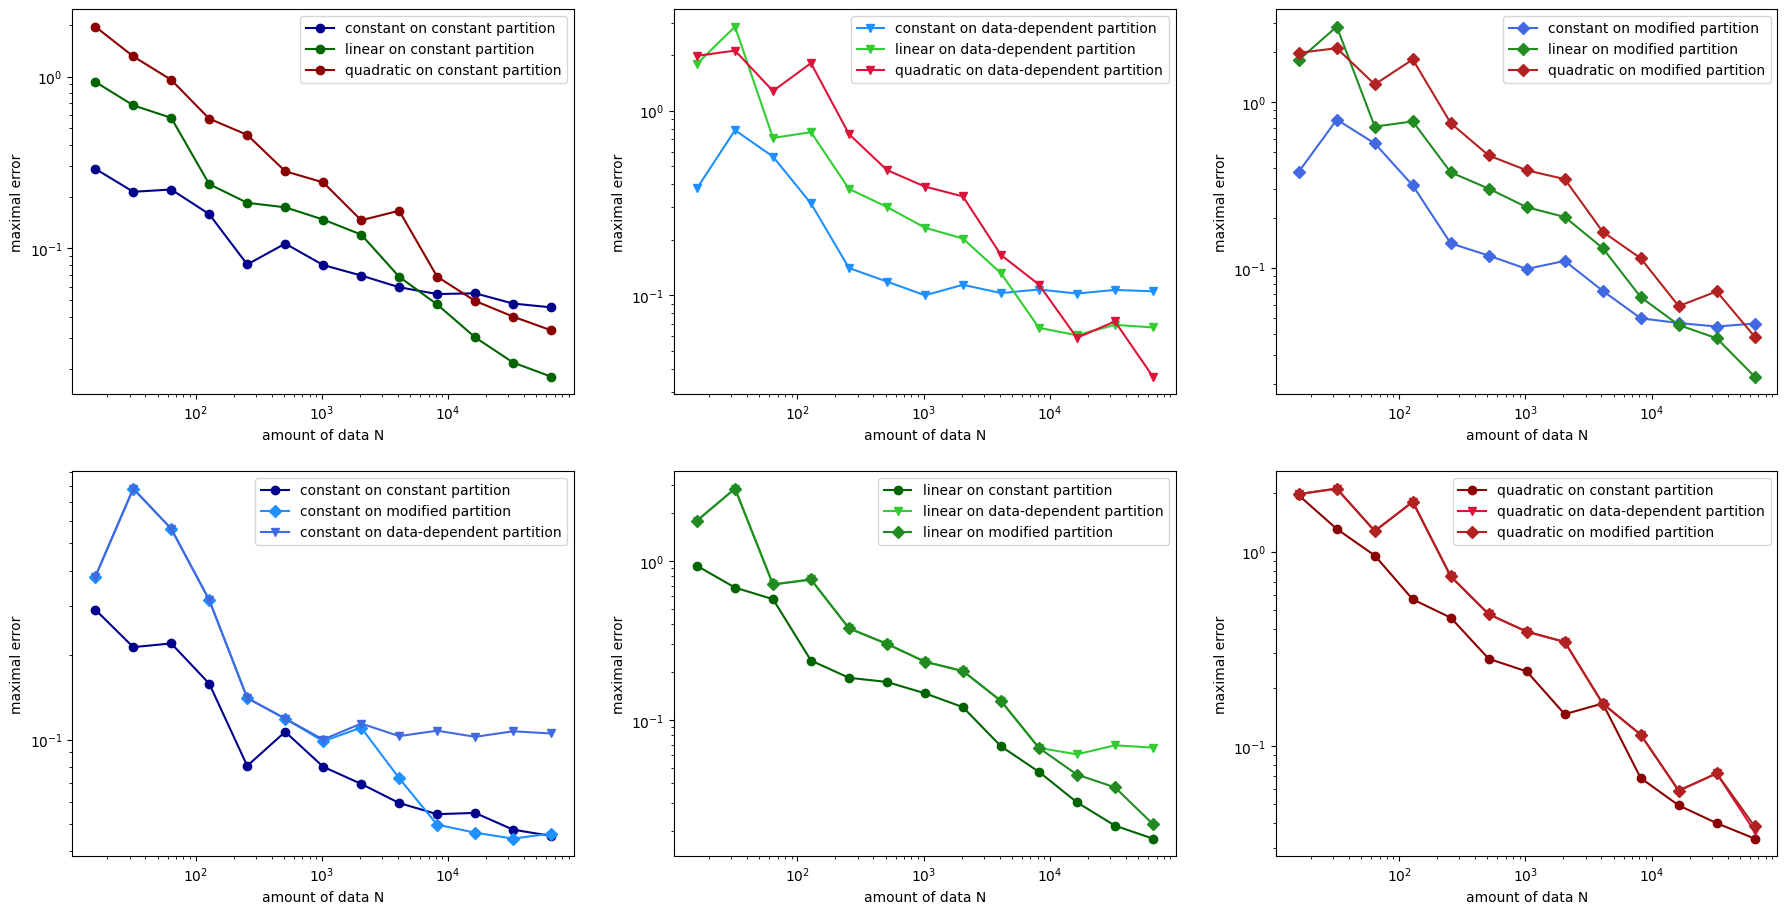

In [16]:
list = np.arange(min_exponent+1, max_exponent+1)
N_interval = 2**list

fig, ax = plt.subplots(2, 3, figsize = (22, 11))

print('for h =', h, 'fixed')

ax[0][0].loglog(N_interval, error[0, :, 0], 'o-', color = 'darkblue', label='constant on constant partition')
ax[0][0].loglog(N_interval, error[1, :, 0], 'o-', color = 'darkgreen', label='linear on constant partition')
ax[0][0].loglog(N_interval, error[2, :, 0], 'o-', color = 'darkred', label='quadratic on constant partition')
ax[0][1].loglog(N_interval, error[0, :, 1], 'v-', color = 'dodgerblue', label='constant on data-dependent partition')
ax[0][1].loglog(N_interval, error[1, :, 1], 'v-', color = 'limegreen', label='linear on data-dependent partition')
ax[0][1].loglog(N_interval, error[2, :, 1], 'v-', color = 'crimson', label='quadratic on data-dependent partition')
ax[0][2].loglog(N_interval, error[0, :, 2], 'D-', color = 'royalblue', label='constant on modified partition')
ax[0][2].loglog(N_interval, error[1, :, 2], 'D-', color = 'forestgreen', label='linear on modified partition')
ax[0][2].loglog(N_interval, error[2, :, 2], 'D-', color = 'firebrick', label='quadratic on modified partition')

ax[1][0].loglog(N_interval, error[0, :, 0], 'o-', color = 'darkblue', label='constant on constant partition')
ax[1][0].loglog(N_interval, error[0, :, 2], 'D-', color = 'dodgerblue', label='constant on modified partition')
ax[1][0].loglog(N_interval, error[0, :, 1], 'v-', color = 'royalblue', label='constant on data-dependent partition')
ax[1][1].loglog(N_interval, error[1, :, 0], 'o-', color = 'darkgreen', label='linear on constant partition')
ax[1][1].loglog(N_interval, error[1, :, 1], 'v-', color = 'limegreen', label='linear on data-dependent partition')
ax[1][1].loglog(N_interval, error[1, :, 2], 'D-', color = 'forestgreen', label='linear on modified partition')
ax[1][2].loglog(N_interval, error[2, :, 0], 'o-', color = 'darkred', label='quadratic on constant partition')
ax[1][2].loglog(N_interval, error[2, :, 1], 'v-', color = 'crimson', label='quadratic on data-dependent partition')
ax[1][2].loglog(N_interval, error[2, :, 2], 'D-', color = 'firebrick', label='quadratic on modified partition')

ax[0][0].legend(loc = 'best')
ax[0][1].legend(loc = 'best')
ax[0][2].legend(loc = 'best')
ax[1][0].legend(loc = 'best')
ax[1][1].legend(loc = 'best')
ax[1][2].legend(loc = 'best')
ax[0][0].set_ylabel('maximal error')
ax[0][1].set_ylabel('maximal error')
ax[0][2].set_ylabel('maximal error')
ax[1][0].set_ylabel('maximal error')
ax[1][1].set_ylabel('maximal error')
ax[1][2].set_ylabel('maximal error')
ax[0][0].set_xlabel('amount of data N')
ax[0][1].set_xlabel('amount of data N')
ax[0][2].set_xlabel('amount of data N')
ax[1][0].set_xlabel('amount of data N')
ax[1][1].set_xlabel('amount of data N')
ax[1][2].set_xlabel('amount of data N')

plt.show()

### for N fixed

In [19]:
N_fixed = 2**20

if max_exponent < 20:
    N_fixed = 2**max_exponent
    
x_data_fixed = x_data[0:N_fixed]

x_min = x_data_fixed.min()
x_max = x_data_fixed.max()

h_list = [1, 1/2, 1/4, 1/5, 1/8, 1/10, 1/16, 1/32, 1/64]

In [20]:
h_error = np.zeros((3, len(h_list), 3))

plot = True
if len(h_list) > 5:
    plot = False

for index in range(len(h_list)):

    t0 = time.time()

    # --- FOR CONSTANT PARTITIONING ------------------------------------------------------------- #

    length = int((x_max - x_min) // h_list[index]) + 1
    tolerance = (h_list[index] - abs((x_max - x_min) % h_list[index])) / 2
    
    con_partition = np.linspace(x_min - tolerance, x_max + tolerance, length, endpoint=True)
    lin_partition = np.linspace(x_min - tolerance, x_max + tolerance, 2*length - 1, endpoint=True)
    qud_partition = np.linspace(x_min - tolerance, x_max + tolerance, 3*length - 2, endpoint=True)

    interval = np.linspace(min(con_partition), max(con_partition), plot_length, endpoint=True)
    y_values = p0(interval, d, alpha)

    [kB_con, kB_lin, kB_qud] = compute_kB(x_data_fixed, con_partition)

    con_est = np.zeros(plot_length)
    lin_est = np.zeros(plot_length)
    qud_est = np.zeros(plot_length)

    for i in range(plot_length):
        con_est[i] = con_value(interval[i], con_partition, kB_con, N_fixed)
        lin_est[i] = lin_value(interval[i], con_partition, kB_lin, N_fixed)
        qud_est[i] = qud_value(interval[i], con_partition, kB_qud, N_fixed)
    
    # --- FOR DATA-DEPENDEND PARTITIONING ------------------------------------------------------- #

    kappa = 0
    while 2**kappa < length:
        kappa = kappa + 1
    if int(math.log2(N_fixed)) < kappa:
        kappa = int(math.log2(N_fixed))
        
    kN = 2**(int(math.log2(N_fixed)) - kappa)
    R = 2**kappa

    datadependent_partition = dd_partition(x_data_fixed, kappa, 1/2)

    con_dd_partition = datadependent_partition
    lin_dd_partition = np.zeros(2*R+1)
    lin_dd_partition[0::2] = datadependent_partition
    lin_dd_partition[1::2] = (datadependent_partition[0:R] + datadependent_partition[1:R+1]) / 2
    qud_dd_partition = np.zeros(3*R+1)
    qud_dd_partition[0::3] = datadependent_partition
    qud_dd_partition[1::3] = datadependent_partition[0:R] + 1/3 * (datadependent_partition[1:R+1] - datadependent_partition[0:R])
    qud_dd_partition[2::3] = datadependent_partition[0:R] + 2/3 * (datadependent_partition[1:R+1] - datadependent_partition[0:R])

    [kB_dd_con, kB_dd_lin, kB_dd_qud] = compute_kB(x_data_fixed, datadependent_partition)

    dd_interval = np.linspace(min(datadependent_partition), max(datadependent_partition), plot_length, endpoint=True)
    dd_y_values = p0(dd_interval, d, alpha)

    con_dd_est = np.zeros(plot_length)
    lin_dd_est = np.zeros(plot_length)
    qud_dd_est = np.zeros(plot_length)

    for i in range(plot_length):
        con_dd_est[i] = con_value(dd_interval[i], con_dd_partition, kB_dd_con, N_fixed)
        lin_dd_est[i] = lin_value(dd_interval[i], con_dd_partition, kB_dd_lin, N_fixed)
        qud_dd_est[i] = qud_value(dd_interval[i], con_dd_partition, kB_dd_qud, N_fixed)

    # --- FOR MODIFIED PARTITIONING ------------------------------------------------------------- #

    kN2 = 2**math.ceil(int(math.log2(N_fixed))/2) 
    kappa2 = math.floor(int(math.log2(N_fixed))/2)
    R2 = 2**kappa2 

    diff = kappa2 - kappa
    if diff < 0:
        diff = 0

    datadependent_partition2 = dd_partition(x_data_fixed, kappa2, 1/2)

    modified_partition = mod_partition(datadependent_partition, datadependent_partition2, diff, 1)
    L = len(modified_partition) - 1

    con_mod_partition = modified_partition
    lin_mod_partition = np.zeros(2*L+1)
    lin_mod_partition[0::2] = modified_partition
    lin_mod_partition[1::2] = (modified_partition[0:L] + modified_partition[1:L+1]) / 2
    qud_mod_partition = np.zeros(3*L+1)
    qud_mod_partition[0::3] = modified_partition
    qud_mod_partition[1::3] = modified_partition[0:L] + 1/3 * (modified_partition[1:L+1] - modified_partition[0:L])
    qud_mod_partition[2::3] = modified_partition[0:L] + 2/3 * (modified_partition[1:L+1] - modified_partition[0:L])

    [kB_mod_con, kB_mod_lin, kB_mod_qud] = compute_kB(x_data_fixed, modified_partition)

    mod_interval = np.linspace(min(modified_partition), max(modified_partition), plot_length, endpoint=True)
    mod_y_values = p0(mod_interval, d, alpha)

    con_mod_est = np.zeros(plot_length)
    lin_mod_est = np.zeros(plot_length)
    qud_mod_est = np.zeros(plot_length)

    for i in range(plot_length):
        con_mod_est[i] = con_value(mod_interval[i], con_mod_partition, kB_mod_con, N_fixed)
        lin_mod_est[i] = lin_value(mod_interval[i], con_mod_partition, kB_mod_lin, N_fixed)
        qud_mod_est[i] = qud_value(mod_interval[i], con_mod_partition, kB_mod_qud, N_fixed)

    t1 = time.time()

    print('h = 1/{}: time = {}'.format(int(1/h_list[index]), round(t1-t0, 4)))

    if plot:

        fig, ax = plt.subplots(3, 3, figsize = (18, 15))

        # --- FOR CONSTANT PARTITIONING ----------------------------------------------------- #

        ax[0][0].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')
        ax[0][1].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')
        ax[0][2].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')

        ax[0][0].plot(con_partition, np.zeros_like(con_partition), '|', markersize = 20, color = 'grey')
        ax[0][1].plot(lin_partition[0::2], np.zeros_like(lin_partition[0::2]), '|', markersize = 20, color = 'grey')
        ax[0][1].plot(lin_partition[1::2], np.zeros_like(lin_partition[1::2]), '|', markersize = 10, color = 'grey')
        ax[0][2].plot(qud_partition[0::3], np.zeros_like(qud_partition[0::3]), '|', markersize = 20, color = 'grey')
        ax[0][2].plot(qud_partition[1::3], np.zeros_like(qud_partition[1::3]), '|', markersize = 10, color = 'grey')
        ax[0][2].plot(qud_partition[2::3], np.zeros_like(qud_partition[2::3]), '|', markersize = 10, color = 'grey')

        for i in range(plot_length):
            con_val = con_value(interval[i], con_partition, kB_con, N_fixed)
            lin_val = con_value(interval[i], lin_partition, kB_lin, N_fixed)
            qud_val = con_value(interval[i], qud_partition, kB_qud, N_fixed)
            ax[0][0].plot(interval[i], con_val, '_', markersize = 1, color = 'blue', alpha = 0.3, label='constant')
            ax[0][1].plot(interval[i], lin_val, '_', markersize = 1, color = 'green', label='linear')
            ax[0][2].plot(interval[i], qud_val, '_', markersize = 1, color = 'red', alpha = 0.3, label='quadratic')

        ax[0][0].plot(interval, con_est, '--', color = 'blue', label='constant')
        ax[0][1].plot(interval, lin_est, '--', color = 'green', label='linear')
        ax[0][2].plot(interval, qud_est, '--', color = 'red', label='quadratic')
        ax[0][0].plot(interval, y_values, '--', color = 'grey')
        ax[0][1].plot(interval, y_values, '--', color = 'grey')
        ax[0][2].plot(interval, y_values, '--', color = 'grey')

        # --- FOR DATA-DEPENDEND PARTITIONING ----------------------------------------------- #

        ax[1][0].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')
        ax[1][1].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')
        ax[1][2].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')

        ax[1][0].plot(con_dd_partition, np.zeros_like(con_dd_partition), '|', markersize = 20, color = 'grey')
        ax[1][1].plot(lin_dd_partition[0::2], np.zeros_like(lin_dd_partition[0::2]), '|', markersize = 20, color = 'grey')
        ax[1][1].plot(lin_dd_partition[1::2], np.zeros_like(lin_dd_partition[1::2]), '|', markersize = 10, color = 'grey')
        ax[1][2].plot(qud_dd_partition[0::3], np.zeros_like(qud_dd_partition[0::3]), '|', markersize = 20, color = 'grey')
        ax[1][2].plot(qud_dd_partition[1::3], np.zeros_like(qud_dd_partition[1::3]), '|', markersize = 10, color = 'grey')
        ax[1][2].plot(qud_dd_partition[2::3], np.zeros_like(qud_dd_partition[2::3]), '|', markersize = 10, color = 'grey')

        for i in range(plot_length):
            con_val = con_value(dd_interval[i], con_dd_partition, kB_dd_con, N_fixed)
            lin_val = con_value(dd_interval[i], lin_dd_partition, kB_dd_lin, N_fixed)
            qud_val = con_value(dd_interval[i], qud_dd_partition, kB_dd_qud, N_fixed)
            ax[1][0].plot(dd_interval[i], con_val, '_', markersize = 1, color = 'blue', alpha = 0.3, label='constant')
            ax[1][1].plot(dd_interval[i], lin_val, '_', markersize = 1, color = 'green', alpha = 0.3, label='linear')
            ax[1][2].plot(dd_interval[i], qud_val, '_', markersize = 1, color = 'red', alpha = 0.3, label='quadratic')

        ax[1][0].plot(dd_interval, con_dd_est, '--', color = 'blue', label='constant')
        ax[1][1].plot(dd_interval, lin_dd_est, '--', color = 'green', label='linear')
        ax[1][2].plot(dd_interval, qud_dd_est, '--', color = 'red', label='quadratic')
        ax[1][0].plot(dd_interval, dd_y_values, '--', color = 'grey')
        ax[1][1].plot(dd_interval, dd_y_values, '--', color = 'grey')
        ax[1][2].plot(dd_interval, dd_y_values, '--', color = 'grey')

        # --- FOR MODIFIED PARTITIONING ----------------------------------------------------- #

        ax[2][0].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')
        ax[2][1].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')
        ax[2][2].plot(x_data_fixed, np.zeros_like(x_data_fixed), '.', alpha = 0.5, markersize = 5, color = 'grey')

        ax[2][0].plot(con_mod_partition, np.zeros_like(con_mod_partition), '|', markersize = 20, color = 'grey')
        ax[2][1].plot(lin_mod_partition[0::2], np.zeros_like(lin_mod_partition[0::2]), '|', markersize = 20, color = 'grey')
        ax[2][1].plot(lin_mod_partition[1::2], np.zeros_like(lin_mod_partition[1::2]), '|', markersize = 10, color = 'grey')
        ax[2][2].plot(qud_mod_partition[0::3], np.zeros_like(qud_mod_partition[0::3]), '|', markersize = 20, color = 'grey')
        ax[2][2].plot(qud_mod_partition[1::3], np.zeros_like(qud_mod_partition[1::3]), '|', markersize = 10, color = 'grey')
        ax[2][2].plot(qud_mod_partition[2::3], np.zeros_like(qud_mod_partition[2::3]), '|', markersize = 10, color = 'grey')

        for i in range(plot_length):
            con_val = con_value(mod_interval[i], con_mod_partition, kB_mod_con, N_fixed)
            lin_val = con_value(mod_interval[i], lin_mod_partition, kB_mod_lin, N_fixed)
            qud_val = con_value(mod_interval[i], qud_mod_partition, kB_mod_qud, N_fixed)
            ax[2][0].plot(mod_interval[i], con_val, '_', markersize = 1, color = 'blue', alpha = 0.3, label='constant')
            ax[2][1].plot(mod_interval[i], lin_val, '_', markersize = 1, color = 'green', alpha = 0.3, label='linear')
            ax[2][2].plot(mod_interval[i], qud_val, '_', markersize = 1, color = 'red', alpha = 0.3, label='quadratic')

        ax[2][0].plot(mod_interval, con_mod_est, '--', color = 'blue', label='constant')
        ax[2][1].plot(mod_interval, lin_mod_est, '--', color = 'green', label='linear')
        ax[2][2].plot(mod_interval, qud_mod_est, '--', color = 'red', label='quadratic')
        ax[2][0].plot(mod_interval, mod_y_values, '--', color = 'grey')
        ax[2][1].plot(mod_interval, mod_y_values, '--', color = 'grey')
        ax[2][2].plot(mod_interval, mod_y_values, '--', color = 'grey')

        fig.suptitle(r'comparison of estimators for $N = 2^{{}}$ datapoints, $h_N = \frac{{1}}{{{}}}$'.format(int(math.log2(N_fixed)), int(1/h_list[index])))
        ax[0][0].set_title(r'$f_{n, 0}$ for constant partition', size = 16)
        ax[0][1].set_title(r'$f_{n, 1}$ for constant partition', size = 16)
        ax[0][2].set_title(r'$f_{n, 2}$ for constant partition', size = 16)
        ax[1][0].set_title(r'$f_{n, 0}$ for data-dependent partition', size = 16)
        ax[1][1].set_title(r'$f_{n, 1}$ for data-dependent partition', size = 16)
        ax[1][2].set_title(r'$f_{n, 2}$ for data-dependent partition', size = 16)
        ax[2][0].set_title(r'$f_{n, 0}$ for modified partition', size = 16)
        ax[2][1].set_title(r'$f_{n, 1}$ for modified partition', size = 16)
        ax[2][2].set_title(r'$f_{n, 2}$ for modified partition', size = 16)

        plt.show()

    h_error[0, index, 0] = (abs(con_est - y_values)).max()
    h_error[1, index, 0] = (abs(lin_est - y_values)).max()
    h_error[2, index, 0] = (abs(qud_est - y_values)).max()
    h_error[0, index, 1] = (abs(con_dd_est - dd_y_values)).max()
    h_error[1, index, 1] = (abs(lin_dd_est - dd_y_values)).max()
    h_error[2, index, 1] = (abs(qud_dd_est - dd_y_values)).max()
    h_error[0, index, 2] = (abs(con_mod_est - mod_y_values)).max()
    h_error[1, index, 2] = (abs(lin_mod_est - mod_y_values)).max()
    h_error[2, index, 2] = (abs(qud_mod_est - mod_y_values)).max()

h = 1/1: time = 5.2214
h = 1/2: time = 4.9889
h = 1/4: time = 5.4019
h = 1/5: time = 5.1807
h = 1/8: time = 5.323
h = 1/10: time = 5.3189
h = 1/16: time = 5.6353
h = 1/32: time = 6.2717
h = 1/64: time = 6.7399


for N = 2^16 fixed


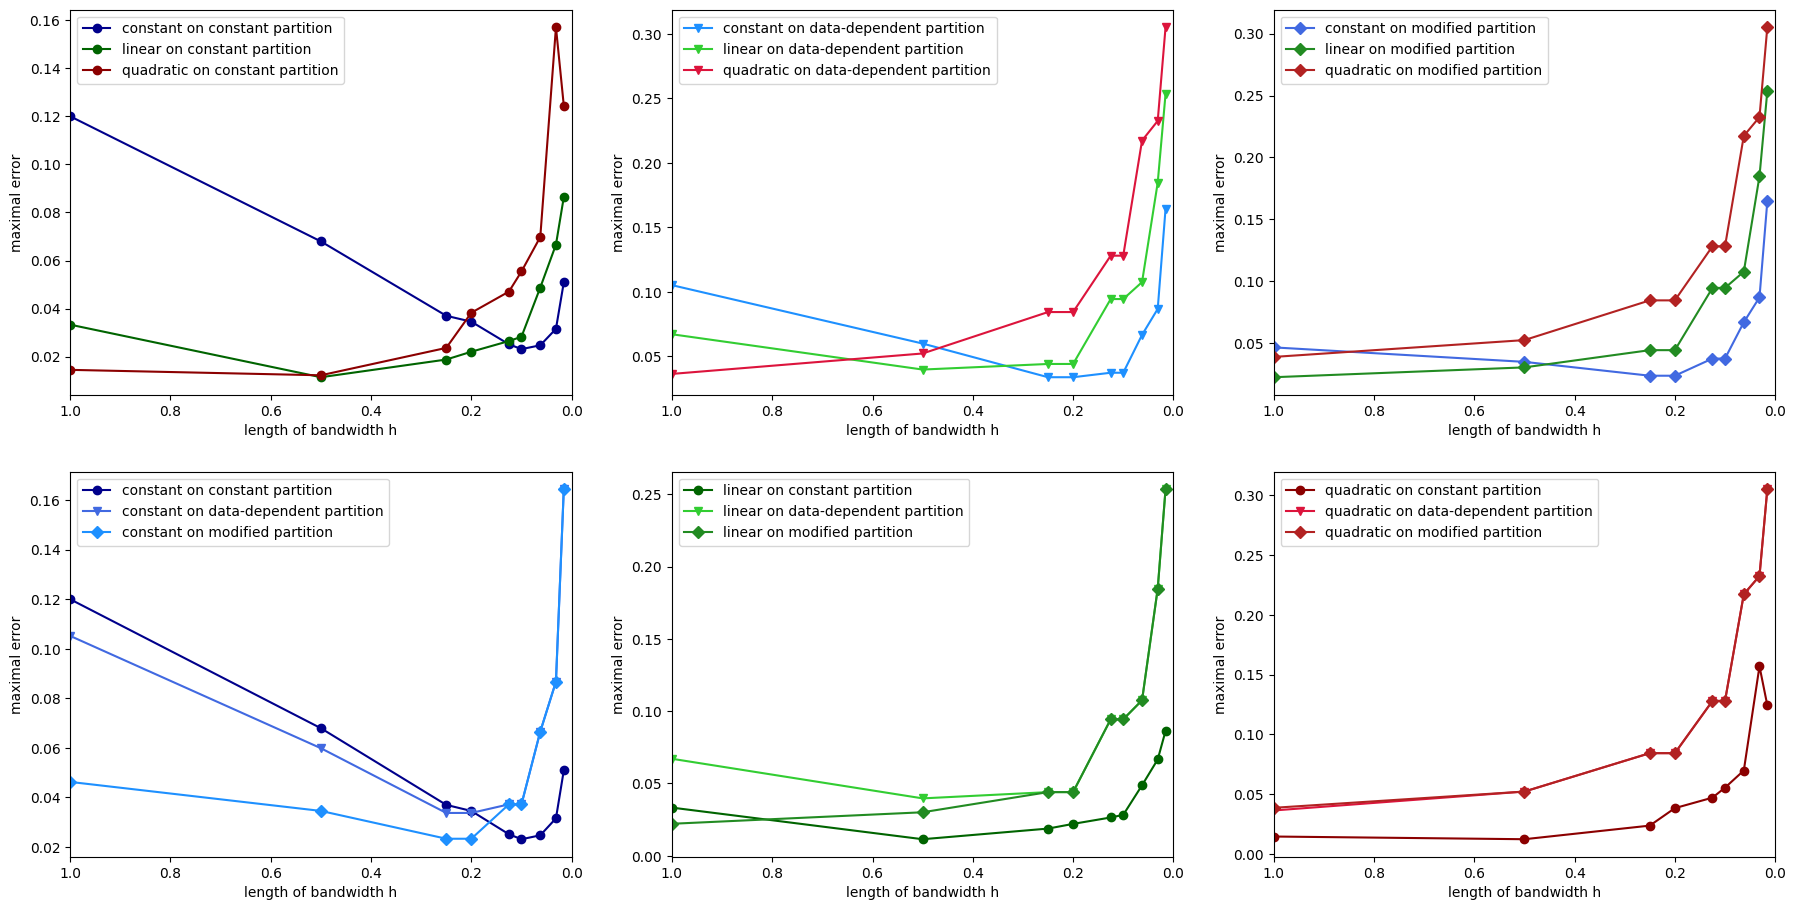

In [21]:
fig, ax = plt.subplots(2, 3, figsize = (22, 11))

print('for N = 2^{} fixed'.format(int(math.log(N_fixed, 2))))

ax[0][0].plot(h_list, h_error[0, :, 0], 'o-', color = 'darkblue', label='constant on constant partition')
ax[0][0].plot(h_list, h_error[1, :, 0], 'o-', color = 'darkgreen', label='linear on constant partition')
ax[0][0].plot(h_list, h_error[2, :, 0], 'o-', color = 'darkred', label='quadratic on constant partition')
ax[0][1].plot(h_list, h_error[0, :, 1], 'v-', color = 'dodgerblue', label='constant on data-dependent partition')
ax[0][1].plot(h_list, h_error[1, :, 1], 'v-', color = 'limegreen', label='linear on data-dependent partition')
ax[0][1].plot(h_list, h_error[2, :, 1], 'v-', color = 'crimson', label='quadratic on data-dependent partition')
ax[0][2].plot(h_list, h_error[0, :, 2], 'D-', color = 'royalblue', label='constant on modified partition')
ax[0][2].plot(h_list, h_error[1, :, 2], 'D-', color = 'forestgreen', label='linear on modified partition')
ax[0][2].plot(h_list, h_error[2, :, 2], 'D-', color = 'firebrick', label='quadratic on modified partition')

ax[1][0].plot(h_list, h_error[0, :, 0], 'o-', color = 'darkblue', label='constant on constant partition')
ax[1][0].plot(h_list, h_error[0, :, 1], 'v-', color = 'royalblue', label='constant on data-dependent partition')
ax[1][0].plot(h_list, h_error[0, :, 2], 'D-', color = 'dodgerblue', label='constant on modified partition')
ax[1][1].plot(h_list, h_error[1, :, 0], 'o-', color = 'darkgreen', label='linear on constant partition')
ax[1][1].plot(h_list, h_error[1, :, 1], 'v-', color = 'limegreen', label='linear on data-dependent partition')
ax[1][1].plot(h_list, h_error[1, :, 2], 'D-', color = 'forestgreen', label='linear on modified partition')
ax[1][2].plot(h_list, h_error[2, :, 0], 'o-', color = 'darkred', label='quadratic on constant partition')
ax[1][2].plot(h_list, h_error[2, :, 1], 'v-', color = 'crimson', label='quadratic on data-dependent partition')
ax[1][2].plot(h_list, h_error[2, :, 2], 'D-', color = 'firebrick', label='quadratic on modified partition')

ax[0][0].set_xlim(1, 0)
ax[0][1].set_xlim(1, 0)
ax[0][2].set_xlim(1, 0)
ax[1][0].set_xlim(1, 0)
ax[1][1].set_xlim(1, 0)
ax[1][2].set_xlim(1, 0)

ax[0][0].legend(loc = 'best')
ax[0][1].legend(loc = 'best')
ax[0][2].legend(loc = 'best')
ax[1][0].legend(loc = 'best')
ax[1][1].legend(loc = 'best')
ax[1][2].legend(loc = 'best')
ax[0][0].set_ylabel('maximal error')
ax[0][1].set_ylabel('maximal error')
ax[0][2].set_ylabel('maximal error')
ax[1][0].set_ylabel('maximal error')
ax[1][1].set_ylabel('maximal error')
ax[1][2].set_ylabel('maximal error')
ax[0][0].set_xlabel('length of bandwidth h')
ax[0][1].set_xlabel('length of bandwidth h')
ax[0][2].set_xlabel('length of bandwidth h')
ax[1][0].set_xlabel('length of bandwidth h')
ax[1][1].set_xlabel('length of bandwidth h')
ax[1][2].set_xlabel('length of bandwidth h')

plt.show()